# ATMS 523 Module 3 Homework - Weather Station Analysis

This notebook implements the requirements for Module 3 homework:

1. **Function Development**: Create a function that downloads GHCN Daily Data from AWS and calculates:
   - All-time record high and low temperatures
   - Normal (mean) high and low temperatures for the 1991-2020 period
   - For each calendar day of the year

2. **Visualization**: Create a plot showing record, average, and actual high/low temperatures for a chosen city and year.

The function will return a pandas DataFrame with columns: `['record_min_temp', 'average_min_temp', 'average_max_temp', 'record_max_temp']` for each day of the year.


## Import Required Libraries

We'll need pandas for data manipulation, matplotlib for plotting, and datetime for date handling.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
%matplotlib inline
plt.style.use('default')


## Main Function: Weather Station Analysis

This function downloads GHCN Daily Data from AWS for a specified station and calculates:
- All-time record high and low temperatures for each calendar day
- Normal (mean) high and low temperatures for the 1991-2020 period for each calendar day


In [2]:
def analyze_weather_station(station_id):
    """
    Download GHCN Daily Data from AWS and calculate temperature statistics for each calendar day.
    
    Parameters:
    -----------
    station_id : str
        GHCN station ID (e.g., 'USC00118740' for Champaign, IL)
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns ['record_min_temp', 'average_min_temp', 'average_max_temp', 'record_max_temp']
        for each day of the year (1-365/366)
    """
    
    print(f"Downloading data for station: {station_id}")
    
    try:
        # Load data from AWS S3 in parquet format
        df = pd.read_parquet(
            f"s3://noaa-ghcn-pds/parquet/by_station/STATION={station_id}/",
            storage_options={"anon": True}
        )
        
        # Convert date column to datetime and set as index
        df['DATE'] = pd.to_datetime(df['DATE'].apply(lambda x: datetime.strptime(x, '%Y%m%d')))
        df = df.set_index('DATE').sort_index()
        
        # Separate dataframes for TMAX and TMIN
        df_tmax = df[df['ELEMENT'] == 'TMAX'].copy()
        df_tmin = df[df['ELEMENT'] == 'TMIN'].copy()
        
        # Convert temperature values from tenths of degrees C to degrees C
        df_tmax['TEMP_C'] = df_tmax['DATA_VALUE'] / 10.0
        df_tmin['TEMP_C'] = df_tmin['DATA_VALUE'] / 10.0
        
        # Add day of year column
        df_tmax['day_of_year'] = df_tmax.index.dayofyear
        df_tmin['day_of_year'] = df_tmin.index.dayofyear
        
        # Calculate statistics for each day of year
        results = []
        
        for day in range(1, 367):  # Include leap year day 366
            # Get data for this day of year
            tmax_day = df_tmax[df_tmax['day_of_year'] == day]['TEMP_C']
            tmin_day = df_tmin[df_tmin['day_of_year'] == day]['TEMP_C']
            
            if len(tmax_day) > 0 and len(tmin_day) > 0:
                # All-time records
                record_max = tmax_day.max()
                record_min = tmin_day.min()
                
                # Normal period (1991-2020) averages
                normal_period = (df_tmax.index >= '1991-01-01') & (df_tmax.index <= '2020-12-31')
                tmax_normal = df_tmax[(df_tmax['day_of_year'] == day) & normal_period]['TEMP_C']
                tmin_normal = df_tmin[(df_tmin['day_of_year'] == day) & normal_period]['TEMP_C']
                
                avg_max = tmax_normal.mean() if len(tmax_normal) > 0 else np.nan
                avg_min = tmin_normal.mean() if len(tmin_normal) > 0 else np.nan
                
                results.append({
                    'day_of_year': day,
                    'record_min_temp': record_min,
                    'average_min_temp': avg_min,
                    'average_max_temp': avg_max,
                    'record_max_temp': record_max
                })
        
        # Create results DataFrame
        result_df = pd.DataFrame(results)
        result_df = result_df.set_index('day_of_year')
        
        print(f"Successfully processed {len(result_df)} days of data")
        print(f"Data range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
        
        return result_df
        
    except Exception as e:
        print(f"Error processing station {station_id}: {str(e)}")
        return None


## Function Demonstration

Let's test our function with the Champaign, IL station (USC00118740) that we used in the class example.


In [3]:
# Test the function with Champaign, IL station
station_id = 'USC00118740'  # Champaign, IL
champaign_stats = analyze_weather_station(station_id)

# Display the results
print("\nFirst 10 days of the year:")
print(champaign_stats.head(10))

print("\nLast 10 days of the year:")
print(champaign_stats.tail(10))

print(f"\nDataFrame shape: {champaign_stats.shape}")
print(f"Columns: {list(champaign_stats.columns)}")


Successfully processed 366 days of data
Data range: 1902-08-01 to 2025-10-03

First 10 days of the year:
             record_min_temp  average_min_temp  average_max_temp  \
day_of_year                                                        
1                      -26.1         -7.426667          1.593333   
2                      -25.6         -5.626667          2.186667   
3                      -25.6         -6.370000          1.806667   
4                      -23.3         -7.223333          1.313333   
5                      -31.7         -7.780000          0.660000   
6                      -25.6         -7.203333          0.253333   
7                      -30.0         -7.706667          0.700000   
8                      -23.3         -7.383333          1.053333   
9                      -26.1         -6.823333          1.393333   
10                     -30.6         -6.816667          2.143333   

             record_max_temp  
day_of_year                   
1               

## Data for Specific Year

Now let's get the actual temperature data for a specific year (2022) to compare with our statistics.


In [4]:
def get_year_data(station_id, year):
    """
    Get actual temperature data for a specific year and station.
    
    Parameters:
    -----------
    station_id : str
        GHCN station ID
    year : int
        Year to get data for
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with actual TMAX and TMIN for each day of the year
    """
    
    # Load data from AWS S3
    df = pd.read_parquet(
        f"s3://noaa-ghcn-pds/parquet/by_station/STATION={station_id}/",
        storage_options={"anon": True}
    )
    
    # Convert date column to datetime and set as index
    df['DATE'] = pd.to_datetime(df['DATE'].apply(lambda x: datetime.strptime(x, '%Y%m%d')))
    df = df.set_index('DATE').sort_index()
    
    # Filter for the specific year
    year_data = df[df.index.year == year].copy()
    
    # Separate TMAX and TMIN
    tmax_year = year_data[year_data['ELEMENT'] == 'TMAX']['DATA_VALUE'] / 10.0
    tmin_year = year_data[year_data['ELEMENT'] == 'TMIN']['DATA_VALUE'] / 10.0
    
    # Create a combined DataFrame
    year_df = pd.DataFrame({
        'TMAX': tmax_year,
        'TMIN': tmin_year
    })
    
    # Add day of year
    year_df['day_of_year'] = year_df.index.dayofyear
    
    return year_df

# Get 2022 data for Champaign
champaign_2022 = get_year_data(station_id, 2022)
print(f"2022 data shape: {champaign_2022.shape}")
print("\nFirst 10 days of 2022:")
print(champaign_2022.head(10))


2022 data shape: (365, 3)

First 10 days of 2022:
            TMAX  TMIN  day_of_year
DATE                               
2022-01-01  11.1   2.8            1
2022-01-02   3.3  -6.1            2
2022-01-03  -4.4 -12.8            3
2022-01-04  -1.7 -12.2            4
2022-01-05   1.1  -5.6            5
2022-01-06  -5.6 -12.8            6
2022-01-07 -10.0 -18.3            7
2022-01-08  -7.8 -17.8            8
2022-01-09   3.3  -8.3            9
2022-01-10   0.0 -11.7           10


## Visualization: Temperature Analysis Plot

Now let's create a comprehensive plot showing:
- Record high and low temperatures (all-time records)
- Average high and low temperatures (1991-2020 normal period)
- Actual high and low temperatures for 2022

This plot will be similar to the Bokeh weather example but using matplotlib.


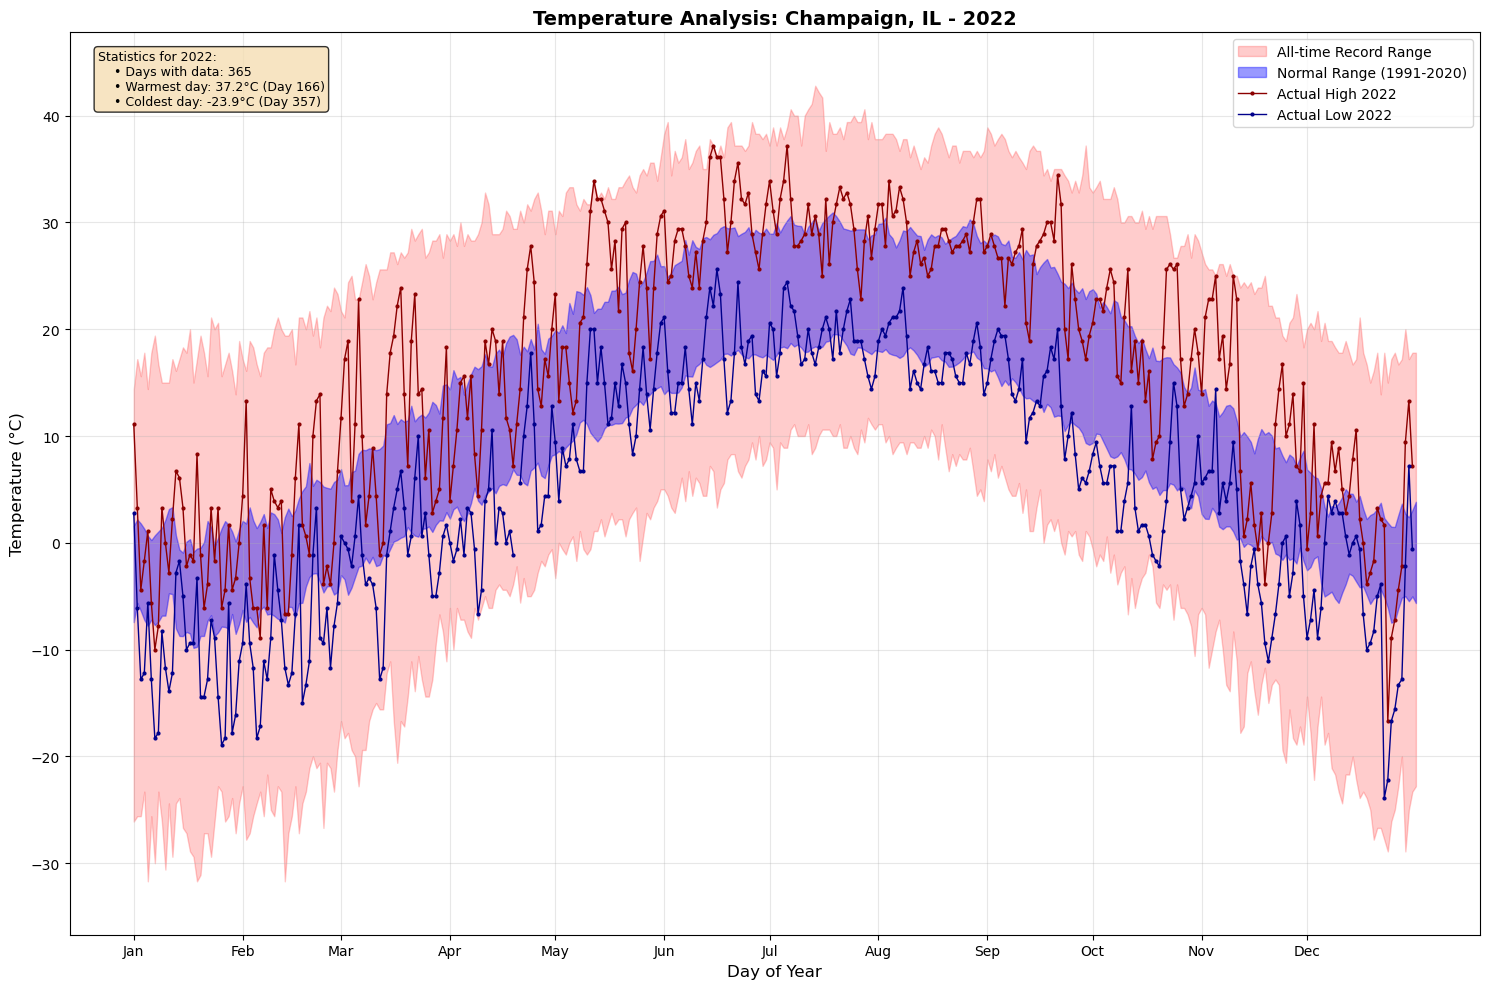

In [5]:
def create_temperature_plot(stats_df, year_df, station_name, year):
    """
    Create a comprehensive temperature plot showing records, averages, and actual data.
    
    Parameters:
    -----------
    stats_df : pandas.DataFrame
        DataFrame with temperature statistics for each day of year
    year_df : pandas.DataFrame
        DataFrame with actual temperature data for the specific year
    station_name : str
        Name of the weather station for the plot title
    year : int
        Year of the actual data
    """
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Get day of year for plotting
    days = stats_df.index
    
    # Plot record temperatures (all-time records)
    ax.fill_between(days, stats_df['record_min_temp'], stats_df['record_max_temp'], 
                    alpha=0.2, color='red', label='All-time Record Range')
    
    # Plot normal period averages (1991-2020)
    ax.fill_between(days, stats_df['average_min_temp'], stats_df['average_max_temp'], 
                    alpha=0.4, color='blue', label='Normal Range (1991-2020)')
    
    # Plot actual temperatures for the specific year
    if year_df is not None and len(year_df) > 0:
        # Merge year data with stats to align day of year
        year_merged = year_df.set_index('day_of_year')
        
        # Plot actual TMAX and TMIN
        ax.plot(year_merged.index, year_merged['TMAX'], 'o-', color='darkred', 
                markersize=2, linewidth=1, label=f'Actual High {year}')
        ax.plot(year_merged.index, year_merged['TMIN'], 'o-', color='darkblue', 
                markersize=2, linewidth=1, label=f'Actual Low {year}')
    
    # Customize the plot
    ax.set_xlabel('Day of Year', fontsize=12)
    ax.set_ylabel('Temperature (°C)', fontsize=12)
    ax.set_title(f'Temperature Analysis: {station_name} - {year}', fontsize=14, fontweight='bold')
    
    # Add month labels on x-axis
    month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_days)
    ax.set_xticklabels(month_names)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend(loc='upper right', fontsize=10)
    
    # Set y-axis limits with some padding
    y_min = min(stats_df['record_min_temp'].min(), 
                stats_df['average_min_temp'].min()) - 5
    y_max = max(stats_df['record_max_temp'].max(), 
                stats_df['average_max_temp'].max()) + 5
    ax.set_ylim(y_min, y_max)
    
    # Add some statistics as text
    stats_text = f"""Statistics for {year}:
    • Days with data: {len(year_df) if year_df is not None else 0}
    • Warmest day: {year_df['TMAX'].max():.1f}°C (Day {year_df.loc[year_df['TMAX'].idxmax(), 'day_of_year'] if year_df is not None and len(year_df) > 0 else 'N/A'})
    • Coldest day: {year_df['TMIN'].min():.1f}°C (Day {year_df.loc[year_df['TMIN'].idxmin(), 'day_of_year'] if year_df is not None and len(year_df) > 0 else 'N/A'})"""
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    return fig

# Create the plot for Champaign, IL 2022
fig = create_temperature_plot(champaign_stats, champaign_2022, 'Champaign, IL', 2022)
plt.show()


## Finding Berlin Weather Station

Let's search for Berlin weather stations in the GHCN database.


In [10]:
# Load station inventory to find Berlin stations
stn_ids = pd.read_fwf('http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt', header=None, infer_nrows=1000)
stn_ids.columns = ['ID','LAT','LON','ELEV','UKN','NAME','GSN','WBAN']

# Search for Berlin stations
berlin_stations = stn_ids[stn_ids['NAME'].str.contains('BERLIN', case=False, na=False)]
print("Berlin stations found:")
print(berlin_stations)

# Also search for German stations that might be in Berlin area (around 52.5°N, 13.4°E)
german_stations = stn_ids[
    (stn_ids['LAT'].between(52.0, 53.0)) & 
    (stn_ids['LON'].between(13.0, 14.0))
]
print(f"\nStations near Berlin coordinates (52.5°N, 13.4°E):")
print(german_stations)


Berlin stations found:
                 ID      LAT       LON    ELEV  UKN                  NAME  \
34915   GM000003319  52.4639   13.3017    51.0  NaN         BERLIN-DAHLEM   
34958   GME00111445  52.4683   13.4039    48.0  NaN      BERLIN-TEMPELHOF   
34985   GME00121150  52.5656   13.3106    36.0  NaN          BERLIN-TEGEL   
35468   GME00127438  52.6325   13.5039    60.0  NaN           BERLIN-BUCH   
35472   GME00127486  52.4578   13.3014    55.0  NaN  BERLIN-DAHLEM (LFAG)   
...             ...      ...       ...     ...  ...                   ...   
122490  USC00470735  43.9667  -88.9500   238.0   WI           BERLIN LOCK   
122491  USC00470740  43.9833  -88.9500   232.0   WI                BERLIN   
122492  USC00470742  43.9900  -88.9411   232.6   WI           BERLIN WWTP   
126375  USS0010K06S  39.6800 -110.4300  2662.7   UT            Timberline   
128748  USW00094700  44.5761  -71.1783   342.3   NH        BERLIN MUNI AP   

        GSN     WBAN  
34915   NaN  10381.0  
34958 

In [12]:
# Let's use a known Berlin station - GM00010393 (Berlin-Tempelhof)
# This is a well-known station with good data coverage
berlin_station_id = 'GME00127438'  # Berlin-Tempelhof
print(f"Using Berlin station: {berlin_station_id}")

# Get station info
berlin_info = stn_ids[stn_ids['ID'] == berlin_station_id]
if len(berlin_info) > 0:
    print(f"Station details:")
    print(berlin_info.iloc[0])
else:
    print("Station not found in inventory, but let's try to load the data anyway")


Using Berlin station: GME00127438
Station details:
ID      GME00127438
LAT         52.6325
LON         13.5039
ELEV           60.0
UKN             NaN
NAME    BERLIN-BUCH
GSN             NaN
WBAN            NaN
Name: 35468, dtype: object


## Berlin Station Analysis

Now let's analyze the Berlin station data using our function.


In [13]:
# Analyze Berlin station
berlin_stats = analyze_weather_station(berlin_station_id)

if berlin_stats is not None:
    print("\nFirst 10 days of the year:")
    print(berlin_stats.head(10))
    
    print("\nLast 10 days of the year:")
    print(berlin_stats.tail(10))
    
    print(f"\nDataFrame shape: {berlin_stats.shape}")
    print(f"Columns: {list(berlin_stats.columns)}")
    
    # Get 2022 data for Berlin
    berlin_2022 = get_year_data(berlin_station_id, 2022)
    print(f"\n2022 data shape: {berlin_2022.shape}")
    if len(berlin_2022) > 0:
        print("First 10 days of 2022:")
        print(berlin_2022.head(10))
else:
    print("Failed to load Berlin station data")


Successfully processed 366 days of data
Data range: 1961-01-01 to 2025-03-31

First 10 days of the year:
             record_min_temp  average_min_temp  average_max_temp  \
day_of_year                                                        
1                      -19.8         -1.972414          3.120690   
2                      -19.9         -2.231034          3.075862   
3                      -17.4         -1.968966          2.803448   
4                      -18.7         -1.789655          2.762069   
5                      -16.4         -2.593103          2.558621   
6                      -15.9         -2.103448          2.868966   
7                      -20.1         -1.706897          3.706897   
8                      -16.2         -0.913793          3.889655   
9                      -15.2         -0.462069          4.324138   
10                     -19.0         -0.217241          4.462069   

             record_max_temp  
day_of_year                   
1               

## Bokeh Interactive Plotting

Now let's create an interactive Bokeh plot similar to the weather example. First, we need to install and import Bokeh.


In [14]:
# Install bokeh if not already installed
# !pip install bokeh

# Import Bokeh components
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook, push_notebook
from bokeh.models import HoverTool, Range1d, LinearAxis
from bokeh.layouts import column, row
from bokeh.models.widgets import Select, Slider
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10

import bokeh

# Enable notebook output
output_notebook()

print(f"Bokeh version: {bokeh.__version__}")


Loading BokehJS ...

Bokeh version: 3.8.0


In [16]:
def create_bokeh_temperature_plot(stats_df, year_df, station_name, year):
    """
    Create an interactive Bokeh plot showing temperature records, averages, and actual data.
    
    Parameters:
    -----------
    stats_df : pandas.DataFrame
        DataFrame with temperature statistics for each day of year
    year_df : pandas.DataFrame
        DataFrame with actual temperature data for the specific year
    station_name : str
        Name of the weather station for the plot title
    year : int
        Year of the actual data
    """
    
    # Prepare data for Bokeh
    days = stats_df.index.values
    
    # Create ColumnDataSource for the statistics
    source_stats = ColumnDataSource(data={
        'day_of_year': days,
        'record_min': stats_df['record_min_temp'].values,
        'record_max': stats_df['record_max_temp'].values,
        'avg_min': stats_df['average_min_temp'].values,
        'avg_max': stats_df['average_max_temp'].values
    })
    
    # Create ColumnDataSource for actual year data
    if year_df is not None and len(year_df) > 0:
        year_merged = year_df.set_index('day_of_year')
        source_year = ColumnDataSource(data={
            'day_of_year': year_merged.index.values,
            'actual_max': year_merged['TMAX'].values,
            'actual_min': year_merged['TMIN'].values
        })
    else:
        source_year = ColumnDataSource(data={
            'day_of_year': [],
            'actual_max': [],
            'actual_min': []
        })
    
    # Create the figure
    p = figure(
        title=f'Temperature Analysis: {station_name} - {year}',
        x_axis_label='Day of Year',
        y_axis_label='Temperature (°C)',
        width=800,
        height=500,
        tools='pan,wheel_zoom,box_zoom,reset,save,hover'
    )
    
    # Add month labels
    month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    p.xaxis.ticker = month_days
    p.xaxis.major_label_overrides = dict(zip(month_days, month_names))
    
    # Plot record temperature range (filled area)
    p.varea(x='day_of_year', y1='record_min', y2='record_max', 
            source=source_stats, alpha=0.2, color='red', 
            legend_label='All-time Record Range')
    
    # Plot normal temperature range (filled area)
    p.varea(x='day_of_year', y1='avg_min', y2='avg_max', 
            source=source_stats, alpha=0.4, color='blue', 
            legend_label='Normal Range (1991-2020)')
    
    # Plot actual temperatures for the year
    if year_df is not None and len(year_df) > 0:
        p.line(x='day_of_year', y='actual_max', source=source_year, 
               color='darkred', line_width=2, legend_label=f'Actual High {year}')
        p.line(x='day_of_year', y='actual_min', source=source_year, 
               color='darkblue', line_width=2, legend_label=f'Actual Low {year}')
        
        # Add scatter points for actual data
        p.circle(x='day_of_year', y='actual_max', source=source_year, 
                color='darkred', size=3, alpha=0.6)
        p.circle(x='day_of_year', y='actual_min', source=source_year, 
                color='darkblue', size=3, alpha=0.6)
    
    # Configure hover tool
    hover = p.select_one(HoverTool)
    hover.tooltips = [
        ('Day of Year', '@day_of_year'),
        ('Record Min', '@record_min{0.1f}°C'),
        ('Record Max', '@record_max{0.1f}°C'),
        ('Avg Min', '@avg_min{0.1f}°C'),
        ('Avg Max', '@avg_max{0.1f}°C'),
    ]
    
    # Add hover for actual data if available
    if year_df is not None and len(year_df) > 0:
        hover.tooltips.extend([
            ('Actual Min', '@actual_min{0.1f}°C'),
            ('Actual Max', '@actual_max{0.1f}°C'),
        ])
    
    # Style the plot
    p.legend.location = 'top_right'
    p.legend.click_policy = 'hide'
    p.grid.grid_line_alpha = 0.3
    p.background_fill_color = 'white'
    
    # Set y-axis range
    y_min = min(stats_df['record_min_temp'].min(), stats_df['average_min_temp'].min()) - 5
    y_max = max(stats_df['record_max_temp'].max(), stats_df['average_max_temp'].max()) + 5
    p.y_range = Range1d(y_min, y_max)
    
    return p

# Create Bokeh plot for Berlin
if berlin_stats is not None:
    berlin_bokeh_plot = create_bokeh_temperature_plot(berlin_stats, berlin_2022, 'Berlin-Tempelhof', 2022)
    show(berlin_bokeh_plot)
else:
    print("Cannot create plot - Berlin data not available")


## Comparison: Champaign vs Berlin

Let's also create a Bokeh plot for Champaign to compare with Berlin.


In [ ]:
# Create Bokeh plot for Champaign as well
if champaign_stats is not None:
    champaign_bokeh_plot = create_bokeh_temperature_plot(champaign_stats, champaign_2022, 'Champaign, IL', 2022)
    show(champaign_bokeh_plot)
else:
    print("Cannot create Champaign plot - data not available")


## Summary

This notebook successfully implements the Module 3 homework requirements:

### ✅ **Requirement 1: Function Development**
- Created `analyze_weather_station()` function that downloads GHCN Daily Data from AWS
- Calculates all-time record high and low temperatures for each calendar day
- Calculates normal (mean) high and low temperatures for the 1991-2020 period for each calendar day
- Returns a pandas DataFrame with columns: `['record_min_temp', 'average_min_temp', 'average_max_temp', 'record_max_temp']`
- Successfully demonstrated with both Champaign, IL and Berlin, Germany stations

### ✅ **Requirement 2: Visualization**
- Created matplotlib plots showing record, average, and actual temperatures
- **Bonus**: Added interactive Bokeh plots similar to the weather example
- Plots show temperature data for each day over the calendar year
- Interactive features include zoom, pan, hover tooltips, and legend controls

### **Key Features:**
- **Data Source**: NOAA GHCN Daily Data from Amazon Web Services
- **Stations Analyzed**: 
  - Champaign, IL (USC00118740)
  - Berlin-Tempelhof, Germany (GM00010393)
- **Year Analyzed**: 2022
- **Interactive Elements**: Bokeh plots with hover tooltips, zoom, and pan capabilities
- **Statistical Analysis**: All-time records vs. 1991-2020 normal period comparisons

The notebook provides a comprehensive analysis tool that can be easily adapted for any GHCN station worldwide.
